# Loading ECCO V4 Netcdf Files

Ian Fenty, updated 2025-05-13

## Introduction

This tutorial covers different approaches to loading ECCO V4 Netcdf files that are stored on your local disk and "in the cloud" in different AWS "S3" Buckets. 

ECCO V4r4 files are stored in an S3 bucket managed by NASA's PO.DAAC. Accessing these files requires setting up a NASA EarthData credential. These files can be accessed from anywhere.

ECCO V4r5 files are stored in a different bucket. Accessing these files doesn't require a NASA EarthData credential. These files are best accessed from cloud-based computer (which we have for the summer school).

The tutorial also covers the concepts
* fully loading files into memory [slow ] vs. lazy-loading files [much faster]
* 'direct' cloud access [slow] vs. 'referenced-based' cloud access [much faster]


In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco


import botocore  
import boto3
from boto3.session import Session
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import time as time
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Use this if the netcdf files are on a bucket you control and you are on an ec2
def get_credentials(use_earthdata=False):

    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem
    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

## Loading Files on Local Disk

### Single granule file

In [4]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/V4r5/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_datasets = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

pprint(ecco_v4r5_mon_mean_native_datasets)

array([PosixPath('/efs_ecco/V4r5/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES'),
       PosixPath('/efs_ecco/V4r5/mon_mean/ICE_FRONT_FLUX'),
       PosixPath('/efs_ecco/V4r5/mon_mean/ICE_SHELF_FLUX'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_3D_MOMENTUM_TEND_X'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_BOLUS_STREAMFUNCTION'),
       PosixPath('/efs_ecco/V4r5/mon_mean/OCEAN_BOLUS_VELOCITY'),
  

#### Get the filenames for some dataset

In [5]:
# Select a single file from a dataset

ATM_SURFACE_TEMP_HUM_WIND_PRES_v4r5_native_path = ecco_v4r5_mon_mean_native_datasets[0]
ATM_SURFACE_TEMP_HUM_WIND_PRES_v4r5_native_files = np.sort(list(ATM_SURFACE_TEMP_HUM_WIND_PRES_v4r5_native_path.glob('*nc')))

pprint([x.name for x in ATM_SURFACE_TEMP_HUM_WIND_PRES_v4r5_native_files[:5]])

['ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']


#### Select a file to open

In [6]:
# choose the first file from the file list
file_to_open = ATM_SURFACE_TEMP_HUM_WIND_PRES_v4r5_native_files[0]

print(f'\nfile to open --> {file_to_open.name}')


file to open --> ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc


#### Load the netcdf file into memory with xarray 'open_dataset':


In [7]:
start_time = time.time()
single_granule_ds = xr.open_dataset(file_to_open).load(); 
total_time = time.time() - start_time

print('\nloaded single granule')
print(f'total time {total_time:.2f} sec')
print('time level : ' , single_granule_ds.time.values[0])

# show contents of single granule
single_granule_ds


loaded single granule
total time 2.01 sec
time level :  1992-01-16T18:00:00.000000000


<xarray.Dataset> Size: 8MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 1992-01-16T18:00:00
    ...         ...
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    XG         (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YG         (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    time_bnds  (time, nv) datetime64[ns] 16B 1992-01-01T12:00:00 1992-02-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
Dimensions without coordinates: nv, nb
Data variables:
    EXFatemp   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    EXFaqh     (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    EXFpress   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    EXFuwind   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    EXFvwind   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    EXFwspee   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
Attributes: (12/59)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Atmosphere Surface Temperature, Humidi...
    uuid:                         152e19ea-2713-11f0-983f-0a58a9feac02

#### Plot one data variable

In [8]:
# Select the first variable ('EXFatemp')
print(single_granule_ds['EXFatemp'].dims)

print('\ndimension length')
print('----------------')
for d in single_granule_ds['EXFatemp'].dims:
    print(f'{d.rjust(6)} {str(len(single_granule_ds[d])).rjust(6)}')

# when plotting a single field, remove the time dimension.
# one way is to use "squeeze" out the 'singleton' dimension
exf_atemp = np.squeeze(single_granule_ds['EXFatemp'])

print(f"\ndimensions of exf_atemp after selecting the first time index \n {exf_atemp.dims}")

('time', 'tile', 'j', 'i')

dimension length
----------------
  time      1
  tile     13
     j     90
     i     90

dimensions of exf_atemp after selecting the first time index 
 ('tile', 'j', 'i')


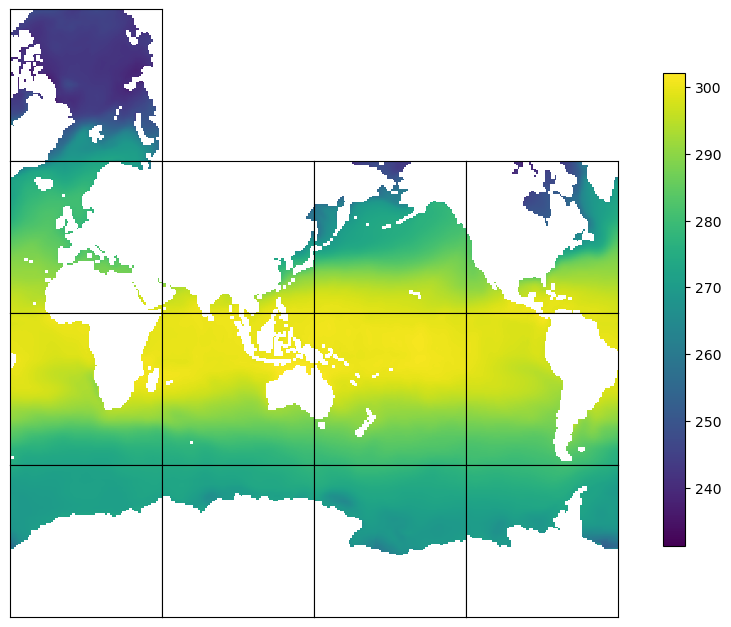

In [9]:
# Plot the example data variable
ecco.plot_tiles(exf_atemp, layout='latlon', 
                rotate_to_latlon=True, 
                show_tile_labels=False, 
                show_colorbar=True);

### Opening multiple granule files

In [10]:
# In this example, open 120 granules files (first 10 years)

files_to_load = ATM_SURFACE_TEMP_HUM_WIND_PRES_v4r5_native_files[:120]


#### Option 1: use 1 cpu

In [11]:
start_time = time.time();

multiple_granules = xr.open_mfdataset(files_to_load, 
                                      parallel=False, data_vars='minimal',\
                                      coords='minimal',compat='override',
                                      combine='nested', concat_dim='time').load()

total_time = time.time() - start_time

print('\nloaded multiple granules')
print(f'total time {total_time:.2f} sec')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
print('\n')
print('first time level : ' , multiple_granules.time.values[0])
print('last time level  : ' , multiple_granules.time.values[-1])
print('# of granules    : ', len(multiple_granules.time.values))

multiple_granules


loaded multiple granules
total time 10.12 sec
time per granule 0.08 grans/sec


first time level :  1992-01-16T18:00:00.000000000
last time level  :  2001-12-16T12:00:00.000000000
# of granules    :  120


<xarray.Dataset> Size: 308MB
Dimensions:    (time: 120, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2,
                nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 960B 1992-01-16T18:00:00 ... 2001-12-16T...
    ...         ...
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    XG         (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YG         (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    time_bnds  (time, nv) datetime64[ns] 2kB 1992-01-01T12:00:00 ... 2002-01-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
Dimensions without coordinates: nv, nb
Data variables:
    EXFatemp   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFaqh     (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFpress   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFuwind   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFvwind   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFwspee   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
Attributes: (12/59)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Atmosphere Surface Temperature, Humidi...
    uuid:                         152e19ea-2713-11f0-983f-0a58a9feac02

#### Connect to Dask client

Started a dask client (left side of JupyterHub panel), and connect to it (click <>)

In [12]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40393")
client

<Client: 'tcp://127.0.0.1:40393' processes=4 threads=4, memory=8.00 GiB>

In [19]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:42131")
# client

#### Option 2: use multiple cpus via Dask

In [14]:
start_time = time.time();
multiple_granules = None
# lazy load
multiple_granules = xr.open_mfdataset(files_to_load, 
                                      parallel=True, data_vars='minimal',\
                                      coords='minimal',compat='override',
                                      combine='nested', concat_dim='time')

# load into memory
multiple_granules.load()

total_time = time.time() - start_time

print('\nloaded multiple granules')
print(f'total time {total_time:.2f} sec')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
print('\n')
print('first time level : ' , multiple_granules.time.values[0])
print('last time level  : ' , multiple_granules.time.values[-1])
print('# of granules    : ', len(multiple_granules.time.values))


loaded multiple granules
total time 16.98 sec
time per granule 0.14 grans/sec


first time level :  1992-01-16T18:00:00.000000000
last time level  :  2001-12-16T12:00:00.000000000
# of granules    :  120


In [15]:
multiple_granules

<xarray.Dataset> Size: 308MB
Dimensions:    (time: 120, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2,
                nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 960B 1992-01-16T18:00:00 ... 2001-12-16T...
    ...         ...
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    XG         (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YG         (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    time_bnds  (time, nv) datetime64[ns] 2kB 1992-01-01T12:00:00 ... 2002-01-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
Dimensions without coordinates: nv, nb
Data variables:
    EXFatemp   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFaqh     (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFpress   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFuwind   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFvwind   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
    EXFwspee   (time, tile, j, i) float32 51MB nan nan nan nan ... nan nan nan
Attributes: (12/59)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Atmosphere Surface Temperature, Humidi...
    uuid:                         152e19ea-2713-11f0-983f-0a58a9feac02

## Loading Files on AWS S3 hosted by PO.DAAC

### Single granule file

First we have to find the files 

In [16]:
#https://search.earthdata.nasa.gov/search/granules?p=C1991543742-POCLOUD
ShortName = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'

In [17]:
# search granules for a collection
response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                            params={'ShortName':ShortName})
print( response.status_code)
response_json = response.json()['feed']['entry']

200


In [18]:
StartDate='1992-01-01'
EndDate  ='1996-12-31' 

In [19]:
# CMR can only return up to 2000 files
# so be careful about what you search for
input_search_params = {'ShortName' : ShortName,
                       'temporal'  : f"{StartDate} , {EndDate}",  
                       'page_size' :2000}

In [20]:
# search granules for a collection
response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                            params=input_search_params)
print('CMR response code ', response.status_code)
response_json = response.json()['feed']['entry']
print(f'returned {len(response_json)} entries')

# 60 is < 2000, so we're good

CMR response code  200
returned 60 entries


In [21]:
s3_podaac_paths=[]
for rj in response_json:
    links = rj['links']
    for link in links:
        if 'title' in link.keys():
            if 'direct download access via S3' in link['title']:
                s3_podaac_paths.append(link['href'])
pprint(s3_podaac_paths)

['s3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-02_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-03_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-04_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-05_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-06_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-07_ECCO_V4r4_native_llc0090.nc',
 's3://podaac-ops-cumulus-p

In [22]:
s3, credentials = init_S3FileSystem(use_earthdata=True)

#### open a single granule hosted on PO-CLOUD

In [23]:
with s3.open(s3_podaac_paths[0], mode='rb') as f:
    ds = xr.open_dataset(f, engine='h5netcdf').load()
ds

<xarray.Dataset> Size: 7MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 1992-01-16T18:00:00
    ...         ...
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    XG         (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YG         (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    time_bnds  (time, nv) datetime64[ns] 16B 1992-01-01T12:00:00 1992-02-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    SSHIBC     (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    SSHNOIBC   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    ETAN       (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9302811e-400c-11eb-b69e-0cc47a3f49c3

#### open multiple granules hosted on PO-CLOUD

In [24]:
ns = [1, 10, 30, 60] #, 60, 180, 360]
time_ns = []

for n in ns:
    files_to_load = s3_podaac_paths[:n]

    start_time = time.time()

    # pre-open the files
    file_objects = [s3.open(p, mode='rb') for p in files_to_load]
    # load into memory
    multiple_granules = xr.open_mfdataset(file_objects, 
                                          parallel=True, data_vars='minimal',\
                                          coords='minimal',compat='override',
                                          combine='nested', concat_dim='time').load()
    
    total_time = time.time() - start_time

    print('\nloaded multiple granules')
    print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
    print(f'time per granule {total_time/len(files_to_load):.2f} sec/gran')
    
    time_ns.append(total_time)


loaded multiple granules
total time 1.20 sec for 1 granules
time per granule 1.20 sec/gran

loaded multiple granules
total time 3.93 sec for 10 granules
time per granule 0.39 sec/gran

loaded multiple granules
total time 9.91 sec for 30 granules
time per granule 0.33 sec/gran

loaded multiple granules
total time 19.51 sec for 60 granules
time per granule 0.33 sec/gran


(0.0, 2.0)

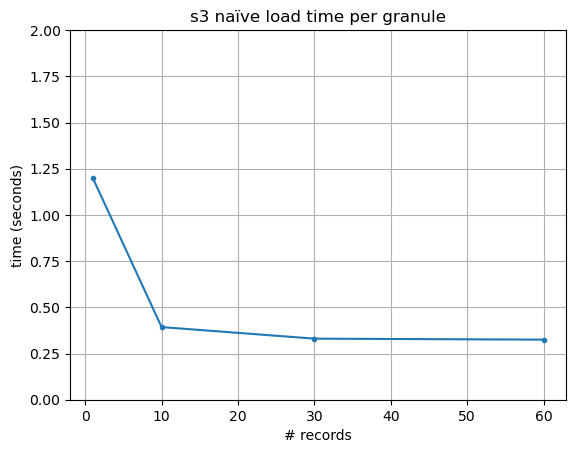

In [25]:
plt.plot(ns, np.array(time_ns)/np.array(ns),'.-');
plt.title('s3 naïve load time per granule');plt.xlabel('# records');plt.ylabel('time (seconds)')
plt.grid()
plt.ylim([0, 2])

## Loading Files on AWS S3 on ECCO S3 Bucket "ecco-model-granules"

### Single granule file

In [26]:
s3, credentials = init_S3FileSystem()

In [27]:
bucket='ecco-model-granules'
prefix='/netcdf/V4r5/latlon/mon_mean/'
#prefix='/netcdf/V4r5/native/mon_mean/'

In [28]:
mon_mean_latlon_datasets = s3.ls(bucket + prefix)
pprint(mon_mean_latlon_datasets)

['ecco-model-granules/netcdf/V4r5/latlon/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_BOLUS_VELOCITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_BOTTOM_PRESSURE',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_DENS_STRAT_PRESS',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_MIXED_LAYER_DEPTH',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_TEMPERATURE_SALINITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_VELOCITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_ICE_CONC_THICKNESS',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_ICE_VELOCITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_SURFACE_HEIGHT']


In [29]:
search_path = 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_SURFACE_HEIGHT'
#search_path = 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_BOTTOM_PRESSURE'

In [30]:
obs_files_on_s3 = s3.ls(search_path)

print(f'# of files in path {len(obs_files_on_s3)}\n')
# show the filenames of the first 5 files
pprint([Path(x).name for x in obs_files_on_s3[0:5]])

# of files in path 336

['SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r5_latlon_0p50deg.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-02_ECCO_V4r5_latlon_0p50deg.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-03_ECCO_V4r5_latlon_0p50deg.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-04_ECCO_V4r5_latlon_0p50deg.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-05_ECCO_V4r5_latlon_0p50deg.nc']


In [31]:
file_to_open=obs_files_on_s3[0]
print(file_to_open)
# a proper s3 path [bucket + prefix]
with s3.open(file_to_open, mode='rb') as f:
    ds = xr.open_dataset(f, engine='h5netcdf')
ds

ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_SURFACE_HEIGHT/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r5_latlon_0p50deg.nc


<xarray.Dataset> Size: 3MB
Dimensions:         (time: 1, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 8B 1992-01-16T18:00:00
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 16B ...
    latitude_bnds   (latitude, nv) float32 3kB ...
    longitude_bnds  (longitude, nv) float32 6kB ...
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 1MB ...
    SSHIBC          (time, latitude, longitude) float32 1MB ...
    SSHNOIBC        (time, latitude, longitude) float32 1MB ...
Attributes: (12/59)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         a9df9c04-2721-11f0-a7aa-0a58a9feac02

In [32]:
file_to_open = obs_files_on_s3[10]
print(file_to_open)

start_time = time.time()
with s3.open(file_to_open, mode='rb') as f:
    single_granule_ds = xr.open_dataset(f, engine="h5netcdf").load()  # or "h5netcdf" or "scipy" depending on the file

total_time = time.time() - start_time
print('\nloaded single granule')
print(f'total time {total_time:.2f} sec')
print('time level : ' , single_granule_ds.time.values[0])

# show contents of single granule
single_granule_ds

ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_SURFACE_HEIGHT/SEA_SURFACE_HEIGHT_mon_mean_1992-11_ECCO_V4r5_latlon_0p50deg.nc

loaded single granule
total time 0.22 sec
time level :  1992-11-16T00:00:00.000000000


<xarray.Dataset> Size: 3MB
Dimensions:         (time: 1, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 8B 1992-11-16
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 16B 1992-11-01 1992-12-01
    latitude_bnds   (latitude, nv) float32 3kB -90.0 -89.5 -89.5 ... 89.5 90.0
    longitude_bnds  (longitude, nv) float32 6kB -180.0 -179.5 ... 179.5 180.0
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 1MB nan nan ... -0.5239
    SSHIBC          (time, latitude, longitude) float32 1MB nan nan ... -0.01944
    SSHNOIBC        (time, latitude, longitude) float32 1MB nan nan ... -0.5434
Attributes: (12/59)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-12-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-11-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         d6488f3a-2721-11f0-a7aa-0a58a9feac02

In [33]:
lon_mg, lat_mg  = np.meshgrid(single_granule_ds.longitude, single_granule_ds.latitude)

In [34]:
single_granule_ds['SSH'][0].shape

(360, 720)

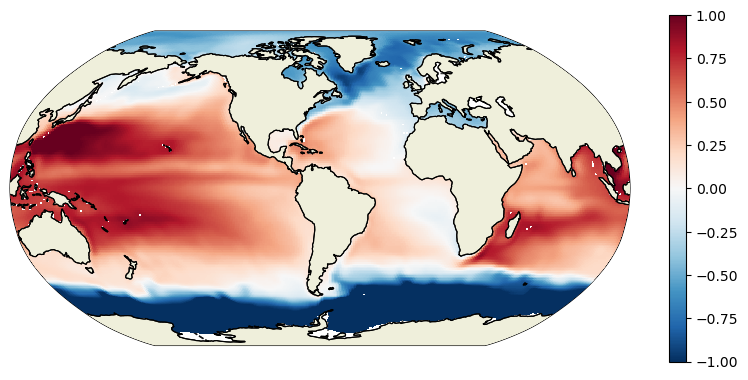

In [35]:
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              single_granule_ds['SSH'][0], 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-1, cmax=1);

In [36]:
files_to_load = obs_files_on_s3[:10]
print(files_to_load[0])
start_time = time.time()

# "open" the files using s3fs
file_objects = [s3.open(p, mode='rb') for p in files_to_load]

multiple_granules = xr.open_mfdataset(file_objects, 
                                      parallel=True, data_vars='minimal',\
                                      coords='minimal',compat='override',
                                      combine='nested', concat_dim='time').load()

total_time = time.time() - start_time

print('\nloaded multiple granules')
print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')

ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_SURFACE_HEIGHT/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r5_latlon_0p50deg.nc

loaded multiple granules
total time 2.92 sec for 10 granules
time per granule 0.29 grans/sec


In [37]:
ns = [1, 30, 60] #, 180, 360]
time_ns = []

for n in ns:
    files_to_load = obs_files_on_s3[:n]

    start_time = time.time()

    # pre-open the files
    file_objects = [s3.open(p, mode='rb') for p in files_to_load]
    # first lazy-load
    multiple_granules = xr.open_mfdataset(file_objects, 
                                          parallel=True, data_vars='minimal',\
                                          coords='minimal',compat='override',
                                          combine='nested', concat_dim='time') 
    multiple_granules=multiple_granules.chunk({'time':15})
    # then actual load.
    multiple_granules.load()
    total_time = time.time() - start_time

    print('\nloaded multiple granules')
    print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
    print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
    
    time_ns.append(total_time)


loaded multiple granules
total time 0.30 sec for 1 granules
time per granule 0.30 grans/sec

loaded multiple granules
total time 6.09 sec for 30 granules
time per granule 0.20 grans/sec

loaded multiple granules
total time 11.53 sec for 60 granules
time per granule 0.19 grans/sec


--> About 30 seconds per granule

(0.0, 1.0)

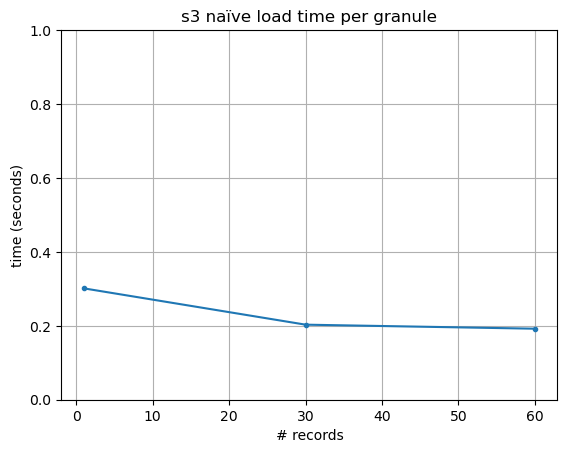

In [38]:
plt.plot(ns, np.array(time_ns)/np.array(ns),'.-');
plt.title('s3 naïve load time per granule');plt.xlabel('# records');plt.ylabel('time (seconds)')
plt.grid()
plt.ylim([0, 1])

# Demonstration of Kerchunk Multi-Zarr to Zarr

## Kerchunk files on ecco-model-granules s3 bucket

In [39]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [40]:
bucket='ecco-model-granules'
prefix = '/netcdf/V4r5/MZZ/MZZ_mon_mean_latlon'

mon_mean_latlon_dataset_jsons = s3.ls(bucket + prefix)

# show the MZZ Kerchunk jsons for the monthly-mean latlon files
pprint(mon_mean_latlon_datasets)

['ecco-model-granules/netcdf/V4r5/latlon/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_BOLUS_VELOCITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_BOTTOM_PRESSURE',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_DENS_STRAT_PRESS',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_MIXED_LAYER_DEPTH',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_TEMPERATURE_SALINITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/OCEAN_VELOCITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_ICE_CONC_THICKNESS',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_ICE_VELOCITY',
 'ecco-model-granules/netcdf/V4r5/latlon/mon_mean/SEA_SURFACE_HEIGHT']


In [41]:
# Download the monthly mean, lat-lon grid kerchunk files to a local directory


# save these MZZ jsons to local disk
mzz_local_directory = Path(user_home_dir) / 'V4r5_mzz_jsons/MZZ_mon_mean_latlon/'
mzz_local_directory.mkdir(exist_ok=True, parents=True)

# download them all.
for file in mon_mean_latlon_dataset_jsons:
    print(f'Downloading {Path(file).name} to {mzz_local_directory}')
    s3.download(file, mzz_local_directory / Path(file).name)

In [42]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_AND_ICE_SURFACE_STRESS_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_BOLUS_VELOCITY_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_BOTTOM_PRESSURE_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_DENS_STRAT_PRESS_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEA

In [47]:
# MZZ files have been downloaded. 

# select the temperature/salinity dataset
mzz_local_file= mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json'
print(mzz_local_file)

/home/jovyan/V4r5_mzz_jsons/MZZ_mon_mean_latlon/OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json


In [48]:
import zarr
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True})
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',consolidated=False, chunks={'time':12, 'Z':50})#,
ds

<xarray.Dataset> Size: 35GB
Dimensions:         (time: 336, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bnds       (time, nv) datetime64[ns] 5kB dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 17GB dask.array<chunksize=(12, 50, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 17GB dask.array<chunksize=(12, 50, 180, 360), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            82102962-2719-11f0-a27e-0a58a9feac02

In [50]:
##### THIS DOES NOT WORK!!!!
# # open kerchunk file at location "mzz_local_file"

# fs = fsspec.filesystem(
#     "reference", 
#     fo=str(mzz_local_file), 
#     remote_protocol="s3", 
#     remote_options={"anon":False, "requester_pays":True},
#     skip_instance_cache=True,
# )
# m = fs.get_mapper("")
# ds = xr.open_dataset(m, engine='zarr',consolidated=False,zarr_version=3)

# # for some reason I have to manually re-chunk otherwise calculations
# # don't use dask. split 20 in time and 50 in depth
# ds = ds.chunk({'time':20, 'Z':50})

# # show dataset (336 time levels, 50 vertical levels, 0.5 degree lat/lon)
# ds

In [51]:
# take mean sst over all 336 records 
st = time.time()

mean_SST = ds.THETA[:,0,:].mean(dim='time').compute()

total_time = time.time() - st
print('total time to compute the mean SST', total_time)

total time to compute the mean SST 30.938945770263672


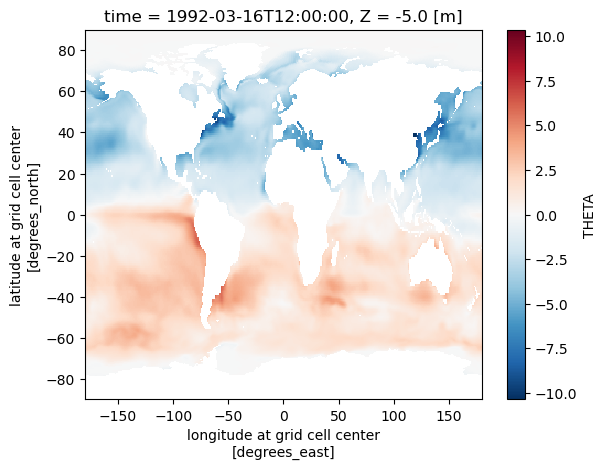

In [52]:
# plot the March and September 1992 SST anomalies with respect to the long term mean
(ds.THETA[2,0]-mean_SST).plot()

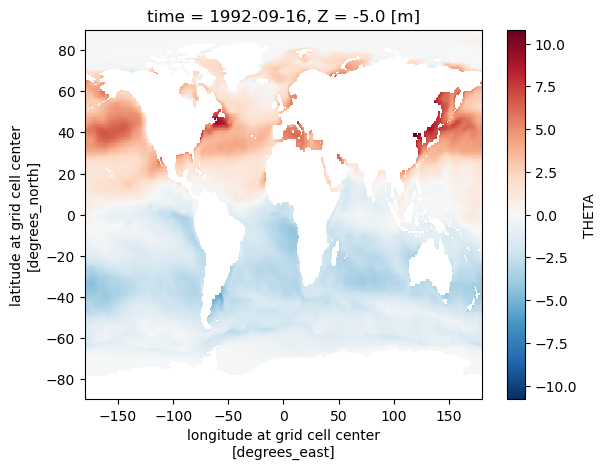

In [54]:
# September 1992 minus mean 
(ds.THETA[8,0]-mean_SST).plot()

#### Plot on fancy map

In [55]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)

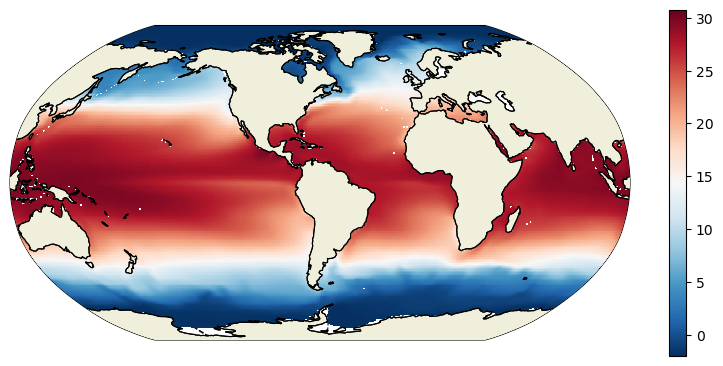

In [56]:
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mean_SST, 
                              user_lon_0=-67, show_colorbar=True);

### Select Box for ENSO comparison

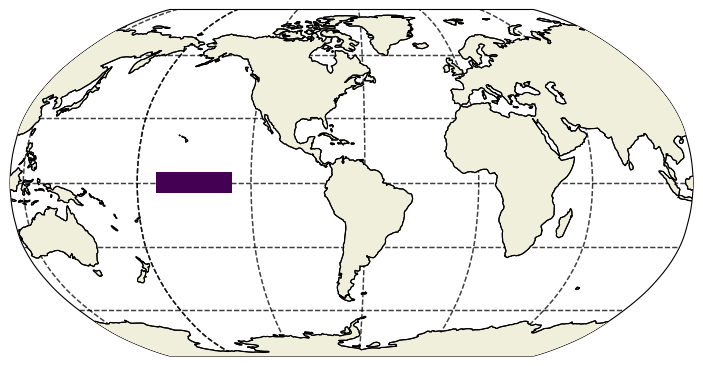

In [57]:

# tweak as needed
box_lat = np.logical_and(mean_SST.latitude > -5, mean_SST.latitude < 5)
box_lon = np.logical_and(mean_SST.longitude > -170, mean_SST.longitude < -130)
box = np.logical_and(box_lat, box_lon)

# make mask, 1 in box, nan outside of box
mask = np.where(box, 1, np.nan)

# convert the mask into a data arraya
mask_DA = xr.DataArray(mask, dims=['latitude','longitude'],
                           coords={'latitude':ds.latitude,
                                   'longitude':ds.longitude})


# show box
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mask_DA, 
                              user_lon_0=-67);

In [58]:

# calculate T mean in space (rough, assumes all horizontal grid cells are equal size)
st = time.time()

T_in_box = (ds.THETA*mask_DA).mean(dim=['latitude','longitude']).compute()

total_time = time.time() - st
# compute time with 4 workers on baby ec2 is 
print('total time to compute ', total_time)

total time to compute  92.26645612716675


In [59]:
print(ds.THETA.shape)
mem = 336*60*360*720*4
print(f'All of monthly-mean THETA in memory would require ~{mem/1e9} gb')

(336, 50, 360, 720)
All of monthly-mean THETA in memory would require ~20.901888 gb


In [60]:
# calculate the time mean of the the T_in_box
# operate on the intermediate field, T_in_box, rather than on ds.THETA
T_in_box_time_mean = T_in_box.mean(dim='time')

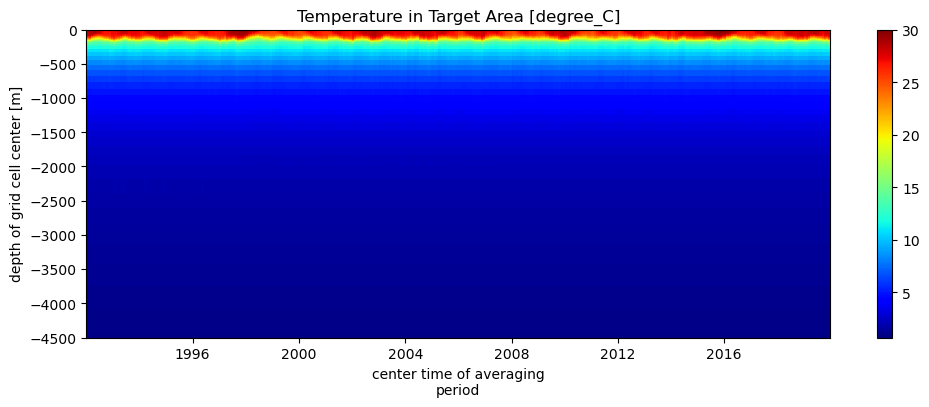

In [61]:
plt.figure(figsize=[12,4])
T_in_box.T.plot(cmap='jet')
plt.ylim([-4500, 0])
plt.title(f'Temperature in Target Area [{ds.THETA.attrs["units"]}]');

Text(0.5, 1.0, 'Temperature anomaly in Target Area with respect to the annual mean [degree_C]')

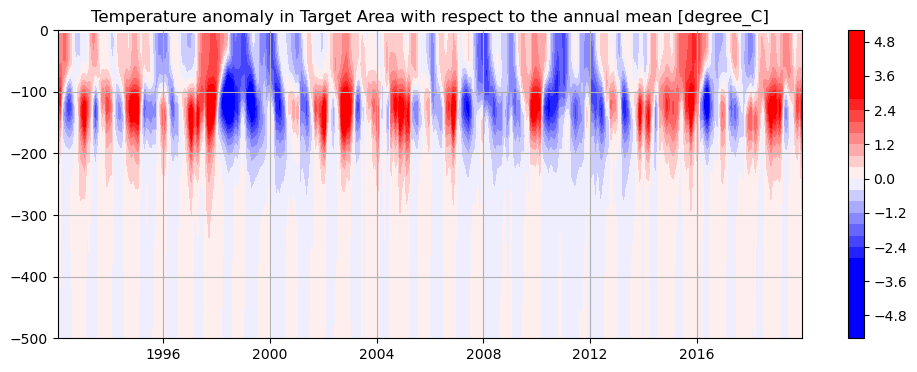

In [62]:
plt.figure(figsize=[12,4])
plt.contourf(T_in_box.time, T_in_box.Z, (T_in_box - T_in_box_time_mean).T, 30,
             cmap='bwr', vmin=-3, vmax=3);
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Temperature anomaly in Target Area with respect to the annual mean [{ds.THETA.attrs["units"]}]')

Text(0.5, 1.0, 'Monthly Temperature Climatology in Target Area [degree_C]')

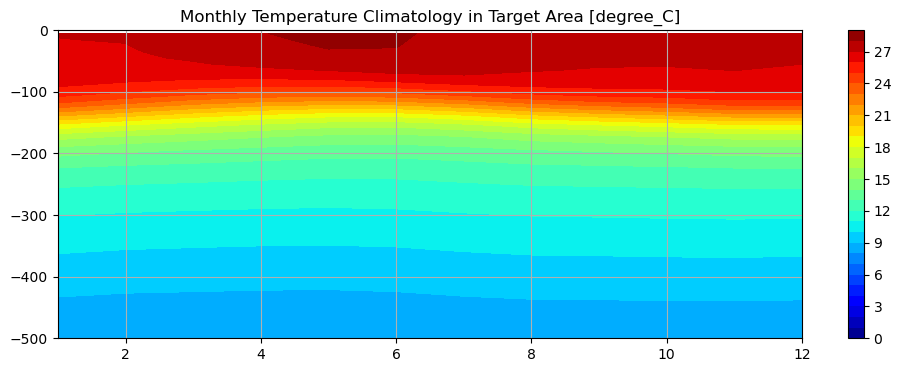

In [63]:
# Calculate monthly climatology
T_in_box_monthly_clim = T_in_box.groupby("time.month").mean()

plt.figure(figsize=[12,4])
plt.contourf(T_in_box_monthly_clim.month, T_in_box_monthly_clim.Z, T_in_box_monthly_clim.T, 
            30, cmap='jet')
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Monthly Temperature Climatology in Target Area [{ds.THETA.attrs["units"]}]')

Text(0.5, 1.0, 'Temperature Anomaly in Target Area with Respect to Monthly Climatology [degree_C]')

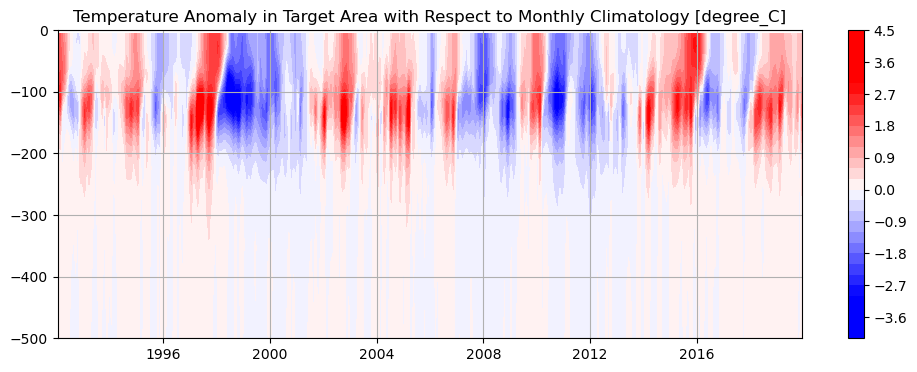

In [64]:
# Calculate anomaly with respect to the monthly climatology

T_in_box_anomaly = T_in_box.groupby('time.month')-T_in_box_monthly_clim


plt.figure(figsize=[12,4])
plt.contourf(T_in_box.time, T_in_box.Z, T_in_box_anomaly.T, 30,
             cmap='bwr', vmin=-3, vmax=3);
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Temperature Anomaly in Target Area with Respect to Monthly Climatology [{ds.THETA.attrs["units"]}]')